In [1]:
%load_ext autoreload
%autoreload 2

In [205]:
import os
from owi_data_2_pandas.io import API
import datetime
from pytz import utc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Import vub Meetenet Vlaamse Banken API functions
from vubmvbc.config import Credentials
from vubmvbc.client import Base
from vubmvbc.objects import Catalog, Data
import vubmvbc.data_getter as dg

from oma_tracking.oma_clustering import ModeClusterer  #pip install hdbscan --no-build-isolation --no-binary :all
from oma_tracking.data.make_dataset import DatasetGetter
from oma_tracking.data.utils import get_rated_data, get_parked_data, read_simulations_csv_files
from oma_tracking.scouring.scouring import aggregate_time_series

First run the mode_tracking notebook for this location!

In [3]:
start =  datetime.datetime(2022,11,1,tzinfo=utc)
stop  = datetime.datetime(2023,3,1,tzinfo=utc)
location = 'nw2d01'
name_location = 'NW2_D01'

# Data Paths
data_path = "../../data/nw2/raw/nw2d01_" + start.strftime("%Y%m%d") + "_" + stop.strftime("%Y%m%d") + ".parquet"
mvbc_path = "../../data/nw2/mvbc_data.parquet"
tracked_frequencies_path = "../../data/nw2/tracked_modes/" + location + ".parquet"
simulations_data_path = "../../data/nw2/simulations/" + location + "/"
simulations_data_path


# Get all the data
data = pd.read_parquet(data_path)
mvbc_data = pd.read_parquet(mvbc_path)
tracked_frequencies = pd.read_parquet(tracked_frequencies_path)
simulation_data = read_simulations_csv_files(simulations_data_path + "eigen_frequencies/")
simulation_shifts = read_simulations_csv_files(simulations_data_path + "mean_shifts/")
simulation_errors = pd.read_csv(simulations_data_path + "errors/Errors_No_scour.csv", index_col=0)

In [4]:
# Data Transformation
mode_simulation_data = {
    'SS1': pd.DataFrame(),
    'FA1': pd.DataFrame(),
    'SS2': pd.DataFrame(),
    'FA2': pd.DataFrame(),
}
for key in simulation_data.keys():
    if 'Eigen_' in key:
        simulation_data[key].rename(
            columns={
                '1st SS': 'SS1',
                '1st FA': 'FA1',
                '2nd SS': 'SS2',
                '2nd FA': 'FA2',
            }, inplace=True
        )
        for mode in ['SS1', 'FA1', 'SS2', 'FA2']:
            mode_simulation_data[mode][key] = simulation_data[key][mode]

# order the columns
cols = list(simulation_data.keys())
ordered_cols = [cols[0]] + cols[9:11] + cols[1:9] + [cols[11]] + cols[20:22] + cols[12:20]
for mode in ['SS1', 'FA1', 'SS2', 'FA2']:
    mode_simulation_data[mode] = mode_simulation_data[mode][ordered_cols]
    mode_simulation_data[mode].to_csv(simulations_data_path + "mode_frequencies/" + mode + ".csv")

tracked_modes = \
    tracked_frequencies.rename(
        columns = {
            'FA1': '1st FA',
            'FA2': '2nd FA',
            'SS1': '1st SS',
            'SS2': '2nd SS',
        }
    )

SS1


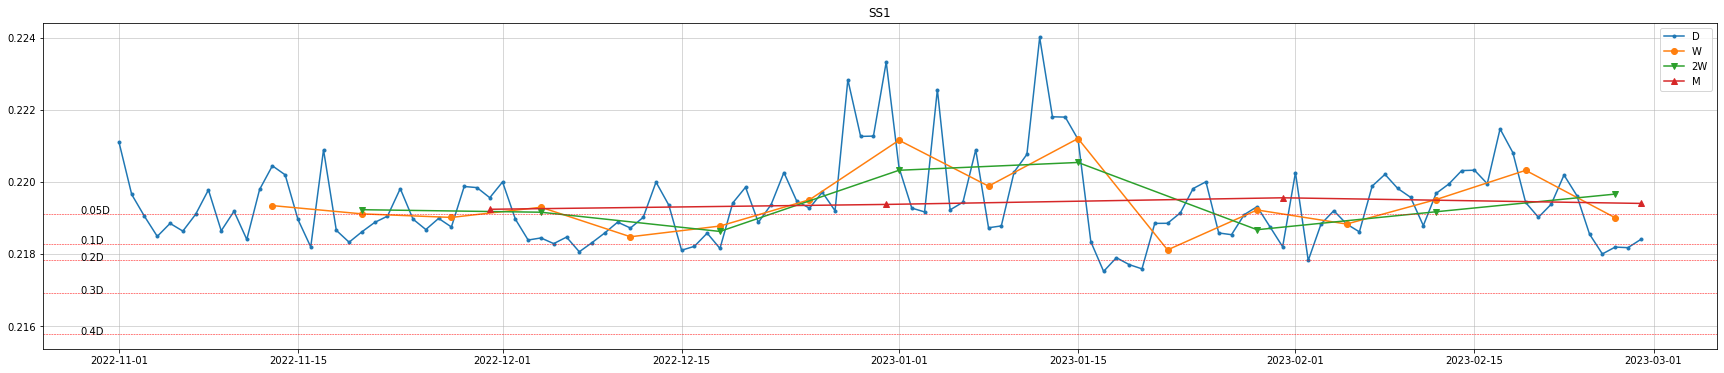

FA1


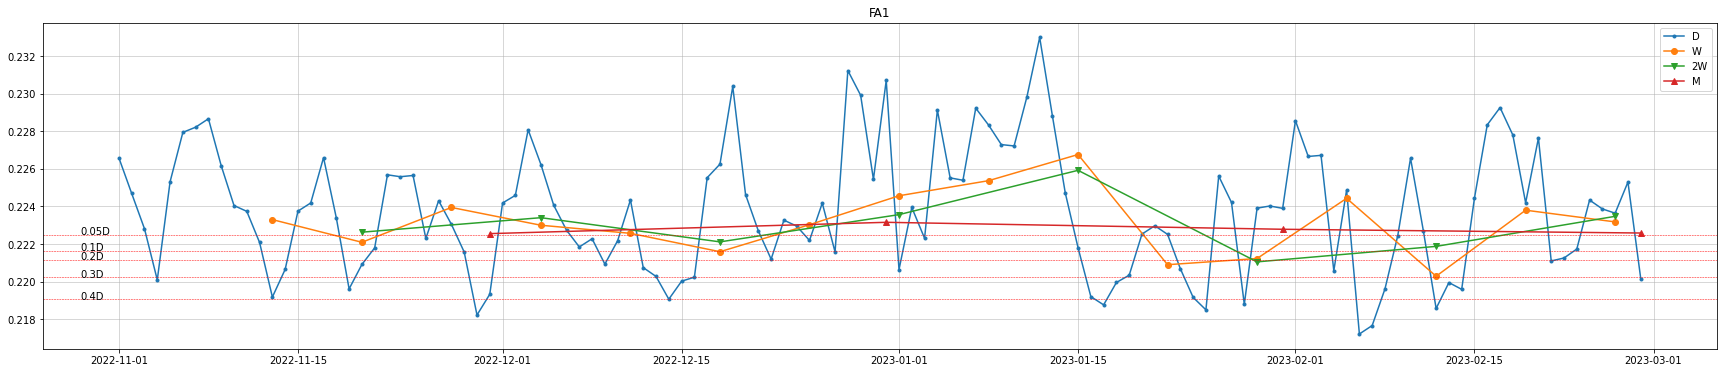

SS2


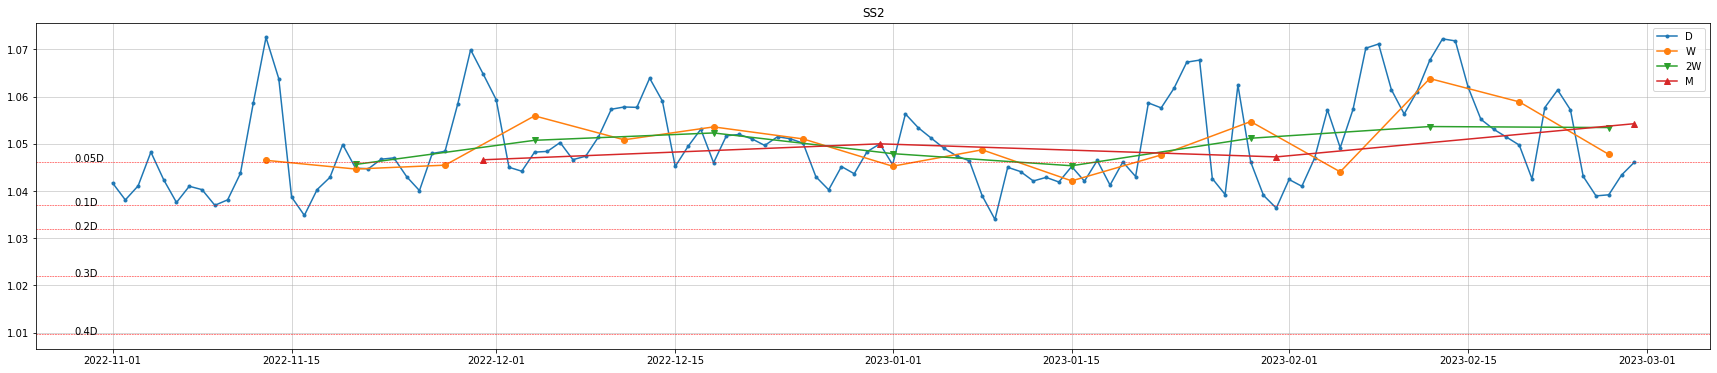

FA2


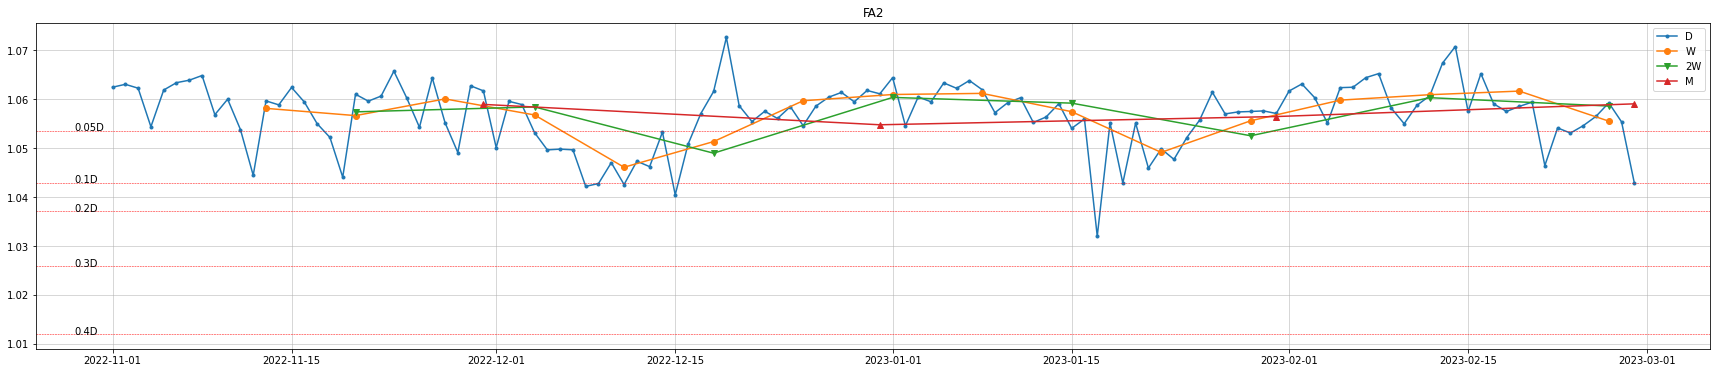

In [206]:
import warnings
warnings.filterwarnings('ignore')
markers = ['.', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_']
for mode in ['SS1', 'FA1', 'SS2', 'FA2']:
    print(mode)
    plt.figure(figsize=(30,6))
    plt.grid('--', linewidth=0.5)
    plt.title(mode)
    m = 0
    i = 0
    for timespan in ['D', 'W', '2W', 'M']:
        timely_tracked_frequencies = aggregate_time_series(tracked_frequencies, timespan)
        plt.plot(timely_tracked_frequencies[mode], label = timespan, marker = markers[m])
        m += 1
    for value in simulation_shifts['parked_scour'][mode].values[:5]:
        plt.axhline(tracked_frequencies[mode].mean() - tracked_frequencies[mode].mean()*value/100, color='red', linestyle='--', linewidth=0.5)
        plt.text(tracked_frequencies[mode].index[0] - datetime.timedelta(days=3), tracked_frequencies[mode].mean() - tracked_frequencies[mode].mean()*value/100, simulation_shifts['parked_scour']['Unnamed: 0'].values[i])
        i += 1
    plt.legend()
    plt.show()

# Visualizations

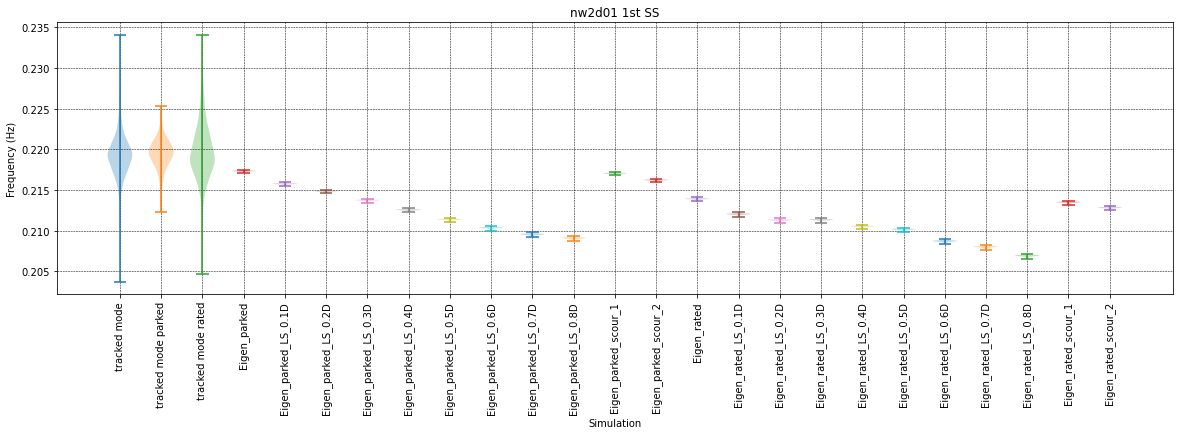

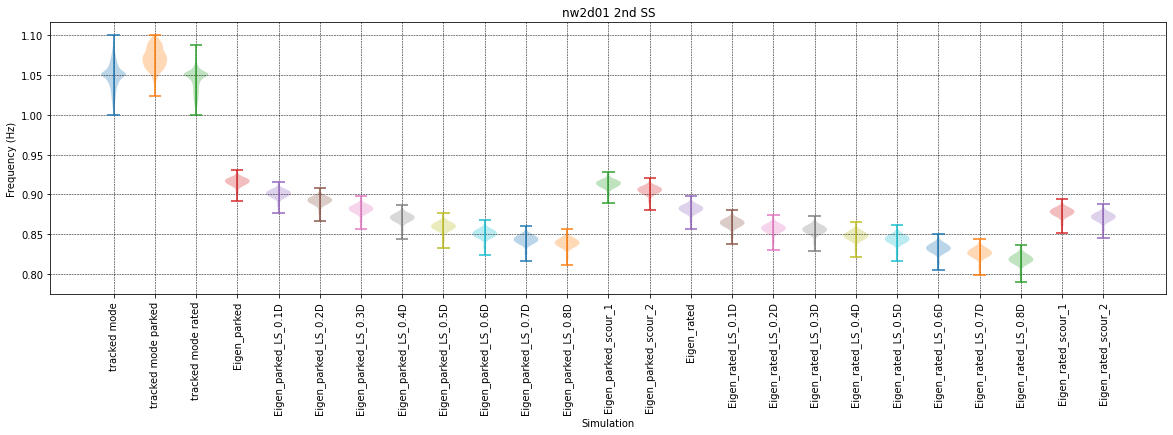

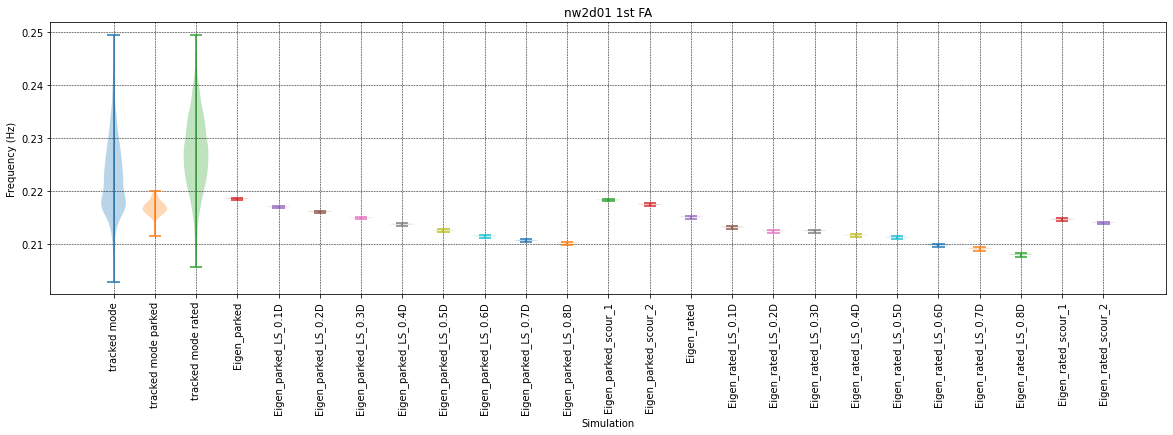

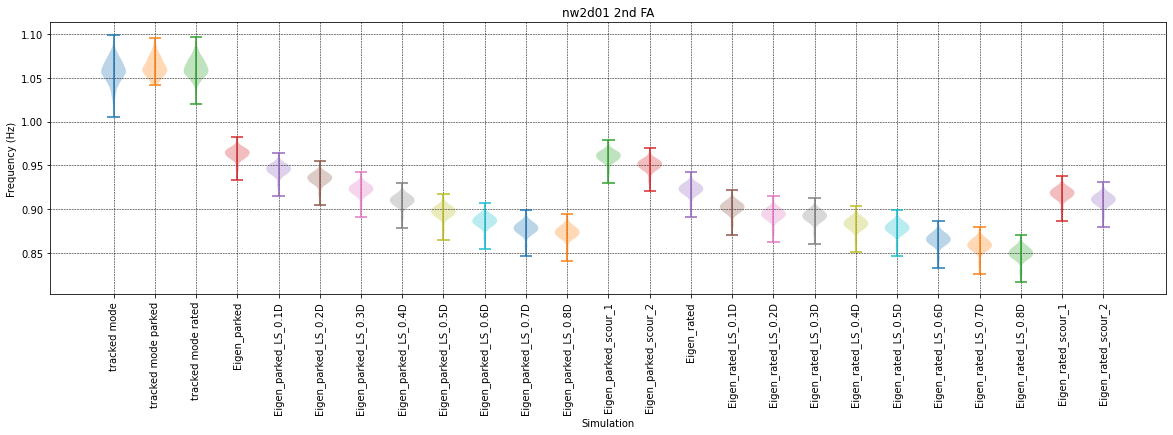

In [105]:
from oma_tracking.visualization.simulation_data_plots import draw_modal_frequency_violinplots, draw_modal_frequency_boxplots
parked_data = get_parked_data(data)
rated_data = get_rated_data(data)
for mode in tracked_modes.columns:
    draw_modal_frequency_violinplots(
        simulation_data,
        tracked_modes,
        parked_data,
        rated_data,
        location,
        mode)


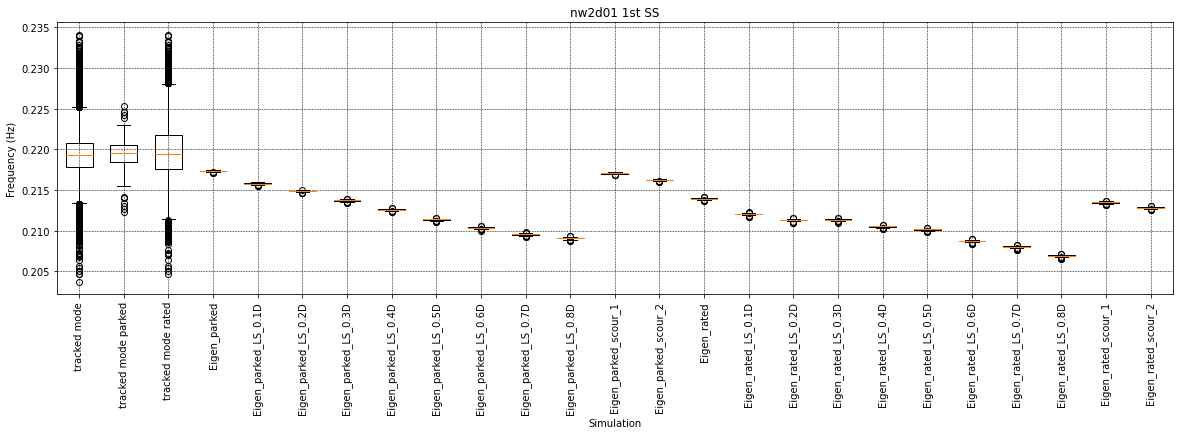

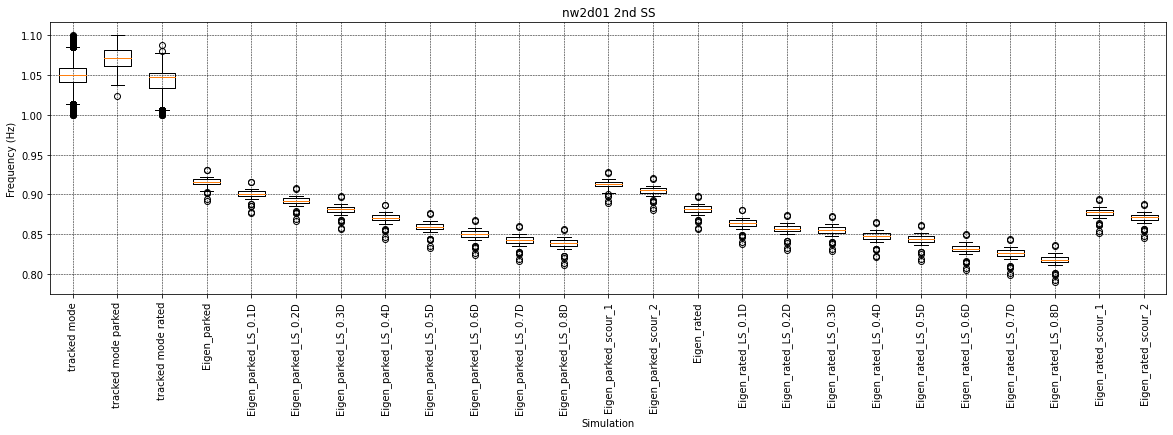

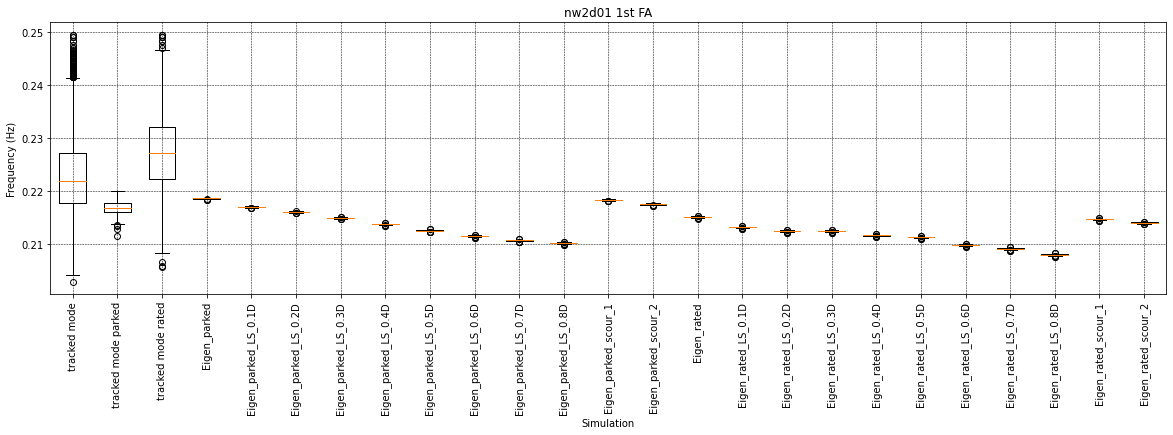

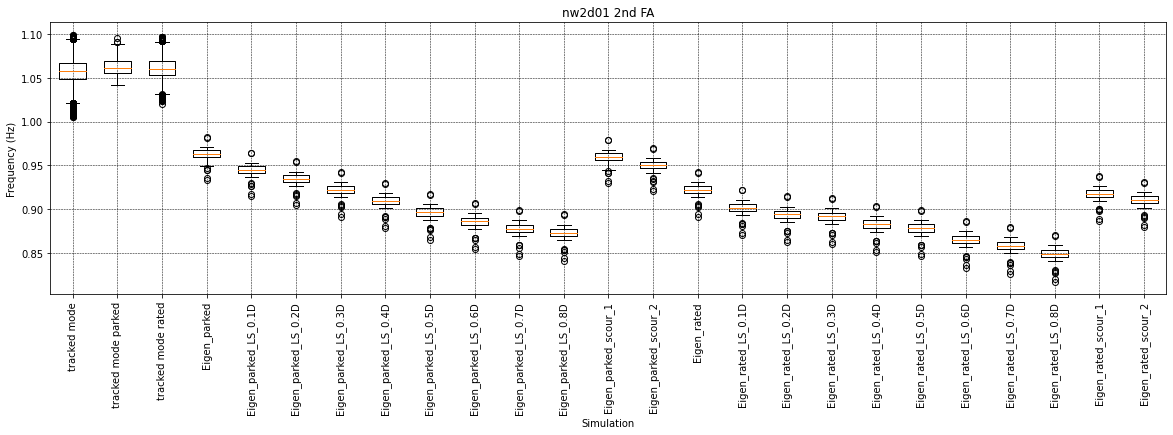

In [106]:
for mode in tracked_modes.columns:    
    draw_modal_frequency_boxplots(
        simulation_data,
        tracked_modes,
        parked_data,
        rated_data,
        location,
        mode)

In [108]:
simulation_data.keys()

dict_keys(['Eigen_parked', 'Eigen_parked_LS_0.1D', 'Eigen_parked_LS_0.2D', 'Eigen_parked_LS_0.3D', 'Eigen_parked_LS_0.4D', 'Eigen_parked_LS_0.5D', 'Eigen_parked_LS_0.6D', 'Eigen_parked_LS_0.7D', 'Eigen_parked_LS_0.8D', 'Eigen_parked_scour_1', 'Eigen_parked_scour_2', 'Eigen_rated', 'Eigen_rated_LS_0.1D', 'Eigen_rated_LS_0.2D', 'Eigen_rated_LS_0.3D', 'Eigen_rated_LS_0.4D', 'Eigen_rated_LS_0.5D', 'Eigen_rated_LS_0.6D', 'Eigen_rated_LS_0.7D', 'Eigen_rated_LS_0.8D', 'Eigen_rated_scour_1', 'Eigen_rated_scour_2', 'Errors_No_scour'])

In [114]:
simulation_data['Eigen_parked'].iloc[:,1]

0     0.217292
1     0.217308
2     0.217315
3     0.217316
4     0.217307
        ...   
58    0.217211
59    0.217189
60    0.217080
61    0.217063
62    0.217240
Name: 1st SS, Length: 63, dtype: float64

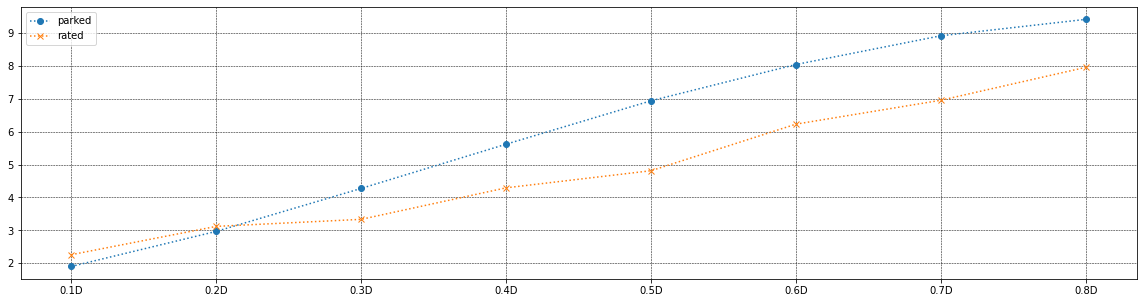

In [158]:
parked_decrease = {}
rated_decrease = {}
mode = '2nd FA'
for key in simulation_data.keys():
    mean_mode_parked = simulation_data['Eigen_parked'].loc[:,mode].mean()
    mean_mode_rated = simulation_data['Eigen_rated'].loc[:,mode].mean()
    if 'parked_LS' in key:
        mean_mode_scenario = simulation_data[key].loc[:,mode].mean()
        mean_decrease = (mean_mode_parked - mean_mode_scenario)/mean_mode_parked * 100
        parked_decrease[key.split("_")[-1]] = mean_decrease
    
    if 'rated_LS' in key:
        mean_mode_scenario = simulation_data[key].loc[:,mode].mean()
        mean_decrease = (mean_mode_rated - mean_mode_scenario)/mean_mode_rated * 100
        rated_decrease[key.split("_")[-1]] = mean_decrease
parked_decrease = pd.DataFrame(parked_decrease, index=[0]).T
rated_decrease = pd.DataFrame(rated_decrease, index=[0]).T

plt.figure(figsize=(20,5))
plt.plot(parked_decrease, ':o', label = 'parked')
plt.plot(rated_decrease, ':x', label='rated')
plt.legend()
plt.grid(True, color='k', linestyle='--', linewidth=0.5)
plt.show()

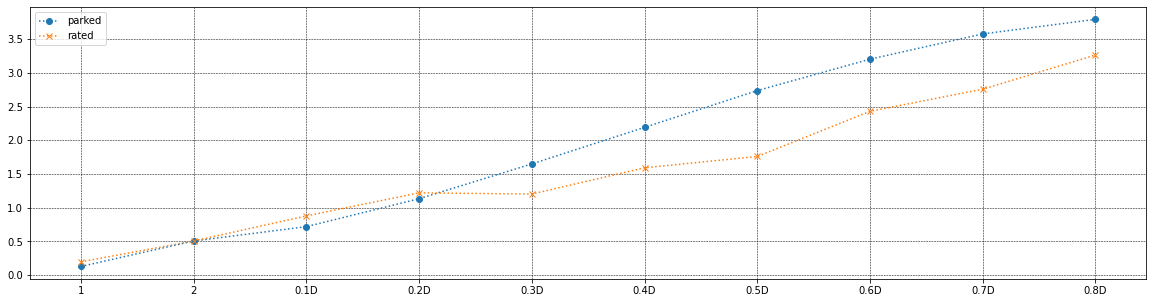

In [172]:
parked_decrease = {}
rated_decrease = {}
mode = '1st SS'
for key in simulation_data.keys():
    mean_mode_parked = simulation_data['Eigen_parked'].loc[:,mode].mean()
    mean_mode_rated = simulation_data['Eigen_rated'].loc[:,mode].mean()
    if 'parked_' in key:
        mean_mode_scenario = simulation_data[key].loc[:,mode].mean()
        mean_decrease = (mean_mode_parked - mean_mode_scenario)/mean_mode_parked * 100
        parked_decrease[key.split("_")[-1]] = mean_decrease
    
    if 'rated_' in key:
        mean_mode_scenario = simulation_data[key].loc[:,mode].mean()
        mean_decrease = (mean_mode_rated - mean_mode_scenario)/mean_mode_rated * 100
        rated_decrease[key.split("_")[-1]] = mean_decrease

parked_decrease = pd.DataFrame(parked_decrease, index=[0]).T
parked_decrease = parked_decrease.loc[parked_decrease.index[-2:].tolist() + parked_decrease.index[:-2].tolist()]
rated_decrease = pd.DataFrame(rated_decrease, index=[0]).T
rated_decrease = rated_decrease.loc[rated_decrease.index[-2:].tolist() + rated_decrease.index[:-2].tolist()]

plt.figure(figsize=(20,5))
plt.plot(parked_decrease, ':o', label = 'parked')
plt.plot(rated_decrease, ':x', label='rated')
plt.legend()
plt.grid(True, color='k', linestyle='--', linewidth=0.5)
plt.show()

In [176]:
simulation_data['Eigen_parked']['1st SS']

0     0.217292
1     0.217308
2     0.217315
3     0.217316
4     0.217307
        ...   
58    0.217211
59    0.217189
60    0.217080
61    0.217063
62    0.217240
Name: 1st SS, Length: 63, dtype: float64

In [186]:
def transform_simulation_data(simulation_data):
    simulation_data_by_mode = {}
    modes = tracked_modes.columns
    for mode in modes:
        parked_df_mode = pd.DataFrame()
        rated_df_mode
        for key in simulation_data.keys():
            if mode in simulation_data[key].columns:
                if 'parked' in key:
                df_mode[key] = simulation_data[key][mode]
        simulation_data_by_mode[mode] = df_mode
    return simulation_data_by_mode

In [187]:
simulation_data_by_mode = transform_simulation_data(simulation_data)

In [199]:
simulation_data_by_mode['1st SS']

,Eigen_parked,Eigen_parked_LS_0.1D,Eigen_parked_LS_0.2D,Eigen_parked_LS_0.3D,Eigen_parked_LS_0.4D,Eigen_parked_LS_0.5D,Eigen_parked_LS_0.6D,Eigen_parked_LS_0.7D,Eigen_parked_LS_0.8D,Eigen_parked_scour_1,...,Eigen_rated_LS_0.1D,Eigen_rated_LS_0.2D,Eigen_rated_LS_0.3D,Eigen_rated_LS_0.4D,Eigen_rated_LS_0.5D,Eigen_rated_LS_0.6D,Eigen_rated_LS_0.7D,Eigen_rated_LS_0.8D,Eigen_rated_scour_1,Eigen_rated_scour_2
0,0.217292,0.215730,0.214828,0.213706,0.212525,0.211339,0.210324,0.209509,0.209039,0.217015,...,0.211993,0.211260,0.211298,0.210463,0.210104,0.208669,0.207967,0.206880,0.213452,0.212789
1,0.217308,0.215747,0.214846,0.213724,0.212543,0.211358,0.210344,0.209529,0.209060,0.217030,...,0.212012,0.211279,0.211317,0.210483,0.210124,0.208690,0.207989,0.206903,0.213470,0.212808
2,0.217315,0.215754,0.214853,0.213731,0.212552,0.211367,0.210353,0.209539,0.209069,0.217037,...,0.212020,0.211288,0.211326,0.210492,0.210133,0.208700,0.207998,0.206913,0.213478,0.212816
3,0.217316,0.215754,0.214852,0.213729,0.212547,0.211361,0.210345,0.209529,0.209059,0.217039,...,0.212015,0.211281,0.211319,0.210484,0.210124,0.208688,0.207985,0.206898,0.213474,0.212812
4,0.217307,0.215744,0.214842,0.213719,0.212537,0.211350,0.210334,0.209518,0.209047,0.217030,...,0.212004,0.211270,0.211308,0.210472,0.210113,0.208676,0.207973,0.206886,0.213464,0.212801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,0.217211,0.215639,0.214732,0.213602,0.212413,0.211219,0.210196,0.209375,0.208901,0.216932,...,0.211876,0.211138,0.211175,0.210333,0.209971,0.208526,0.207818,0.206723,0.213346,0.212679
59,0.217189,0.215616,0.214708,0.213577,0.212386,0.211190,0.210167,0.209345,0.208870,0.216910,...,0.211849,0.211110,0.211146,0.210304,0.209941,0.208494,0.207786,0.206690,0.213320,0.212652
60,0.217080,0.215501,0.214591,0.213456,0.212262,0.211063,0.210037,0.209212,0.208737,0.216799,...,0.211723,0.210982,0.211018,0.210174,0.209810,0.208359,0.207649,0.206550,0.213198,0.212529
61,0.217063,0.215483,0.214571,0.213435,0.212240,0.211039,0.210012,0.209186,0.208710,0.216782,...,0.211700,0.210958,0.210994,0.210148,0.209783,0.208331,0.207620,0.206519,0.213177,0.212507


In [197]:
simulation_data_by_mode['1st SS'].columns

Index(['Eigen_parked', 'Eigen_parked_LS_0.1D', 'Eigen_parked_LS_0.2D',
       'Eigen_parked_LS_0.3D', 'Eigen_parked_LS_0.4D', 'Eigen_parked_LS_0.5D',
       'Eigen_parked_LS_0.6D', 'Eigen_parked_LS_0.7D', 'Eigen_parked_LS_0.8D',
       'Eigen_parked_scour_1', 'Eigen_parked_scour_2', 'Eigen_rated',
       'Eigen_rated_LS_0.1D', 'Eigen_rated_LS_0.2D', 'Eigen_rated_LS_0.3D',
       'Eigen_rated_LS_0.4D', 'Eigen_rated_LS_0.5D', 'Eigen_rated_LS_0.6D',
       'Eigen_rated_LS_0.7D', 'Eigen_rated_LS_0.8D', 'Eigen_rated_scour_1',
       'Eigen_rated_scour_2'],
      dtype='object')

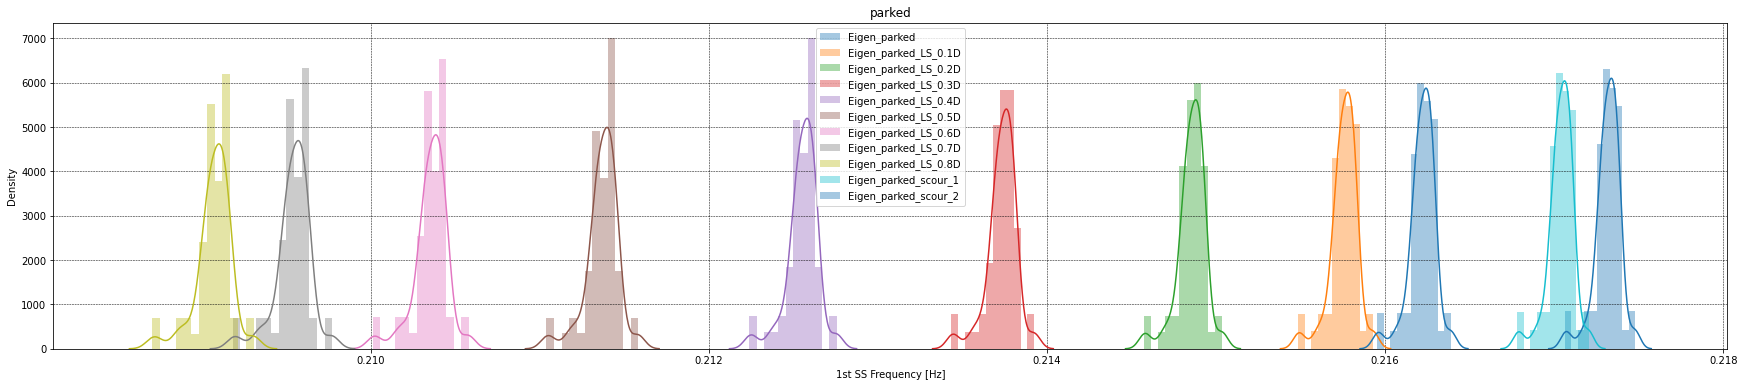

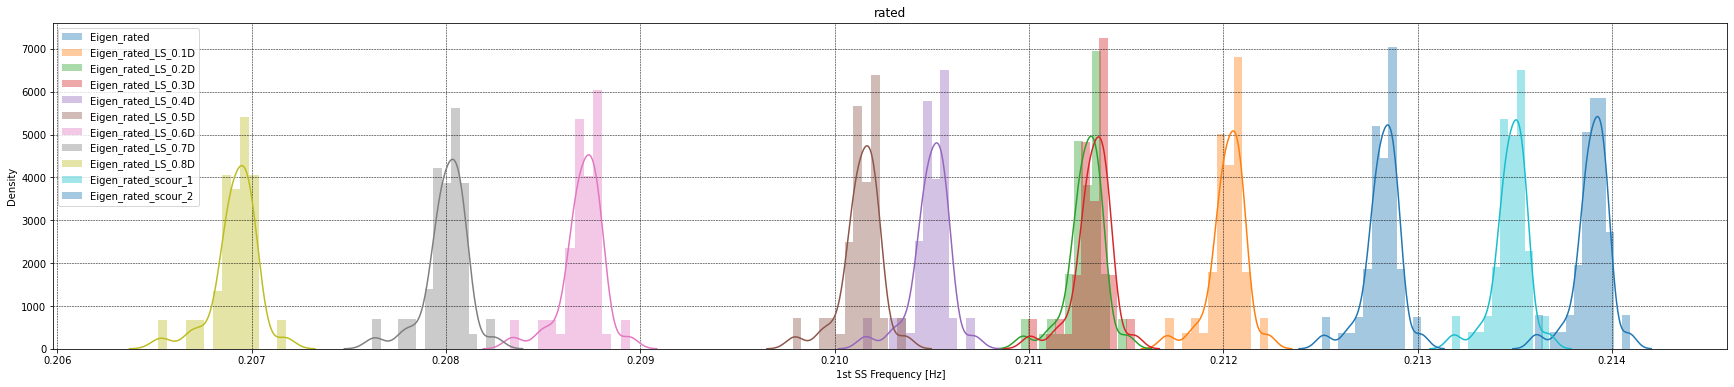

In [195]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
mode = '1st SS'

plt.figure(figsize=(30,6))
plt.grid(True, color='k', linestyle='--', linewidth=0.5)
plt.title('parked')
for col in simulation_data_by_mode[mode]:
    if 'parked' in col:
        sns.distplot(simulation_data_by_mode[mode][col], label=col)
plt.legend()
plt.xlabel(mode + ' Frequency [Hz]')
plt.show()

plt.figure(figsize=(30,6))
plt.grid(True, color='k', linestyle='--', linewidth=0.5)
plt.title('rated')
for col in simulation_data_by_mode[mode]:
    if 'rated' in col:
        sns.distplot(simulation_data_by_mode[mode][col], label=col)
plt.legend()
plt.xlabel(mode + ' Frequency [Hz]')
plt.show()
    

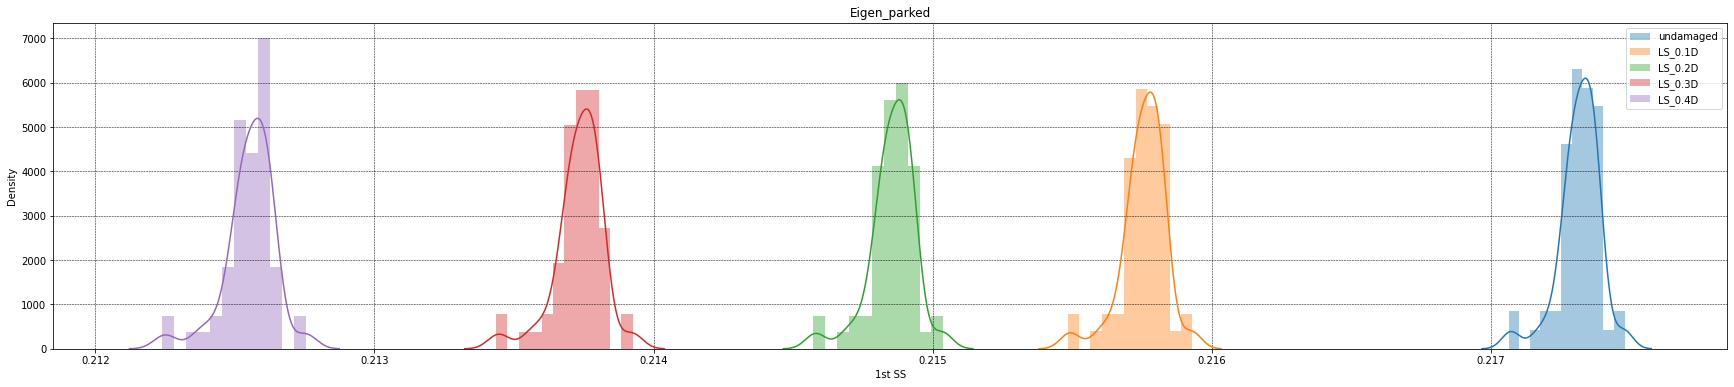

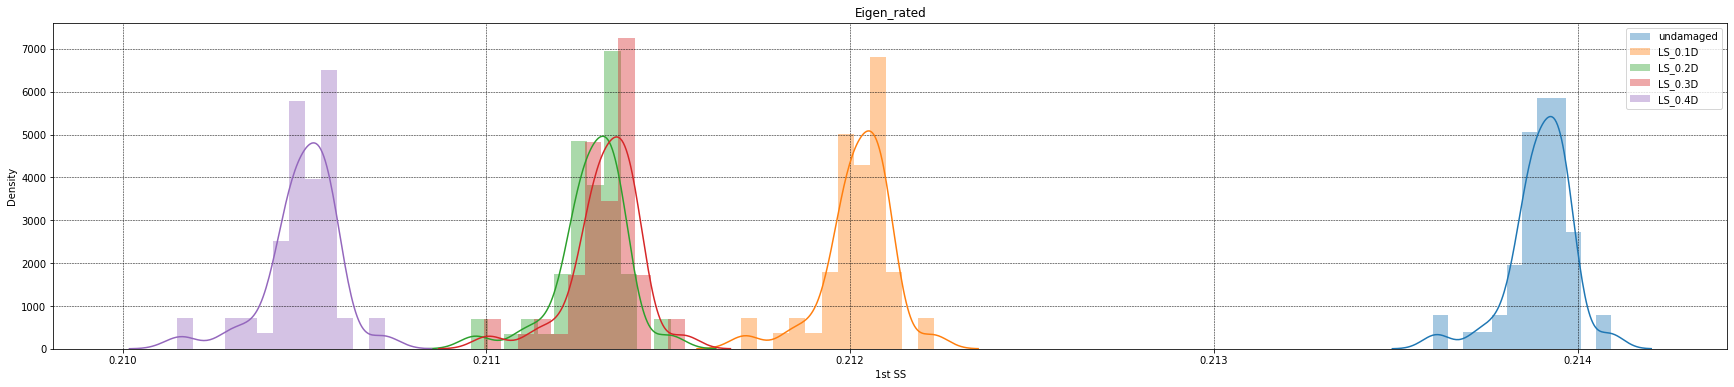

In [129]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
mode_nr = 1

plt.figure(figsize=(30,6))
plt.grid(True, color='k', linestyle='--', linewidth=0.5)
plt.title('Eigen_parked')
sns.distplot(simulation_data['Eigen_parked'].iloc[:,mode_nr], label='undamaged')
sns.distplot(simulation_data['Eigen_parked_LS_0.1D'].iloc[:,mode_nr], label='LS_0.1D')
sns.distplot(simulation_data['Eigen_parked_LS_0.2D'].iloc[:,mode_nr], label='LS_0.2D')
sns.distplot(simulation_data['Eigen_parked_LS_0.3D'].iloc[:,mode_nr], label='LS_0.3D')
sns.distplot(simulation_data['Eigen_parked_LS_0.4D'].iloc[:,mode_nr], label='LS_0.4D')

plt.legend()
plt.show()

plt.figure(figsize=(30,6))
plt.grid(True, color='k', linestyle='--', linewidth=0.5)
plt.title('Eigen_rated')
sns.distplot(simulation_data['Eigen_rated'].iloc[:,mode_nr], label='undamaged')
sns.distplot(simulation_data['Eigen_rated_LS_0.1D'].iloc[:,mode_nr], label='LS_0.1D')
sns.distplot(simulation_data['Eigen_rated_LS_0.2D'].iloc[:,mode_nr], label='LS_0.2D')
sns.distplot(simulation_data['Eigen_rated_LS_0.3D'].iloc[:,mode_nr], label='LS_0.3D')
sns.distplot(simulation_data['Eigen_rated_LS_0.4D'].iloc[:,mode_nr], label='LS_0.4D')

plt.legend()
plt.show()

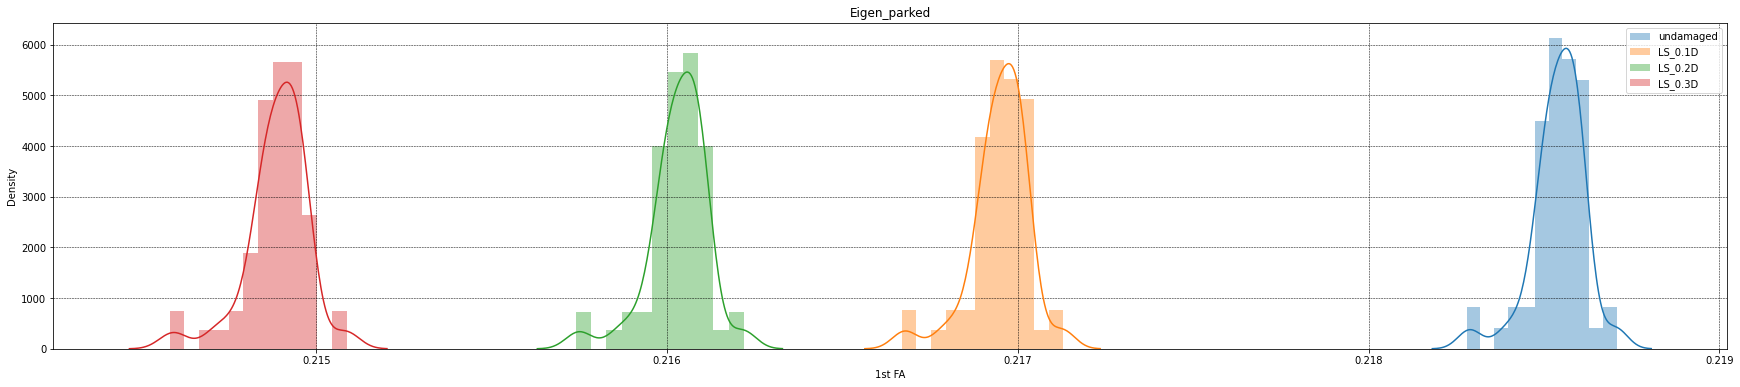

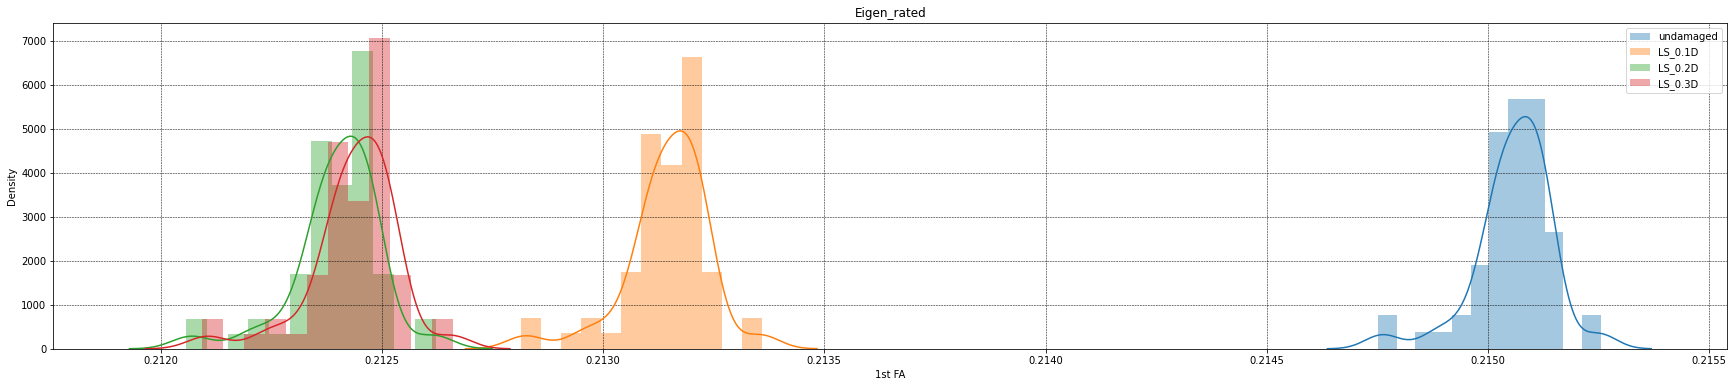

In [128]:
mode_nr = 3

plt.figure(figsize=(30,6))
plt.grid(True, color='k', linestyle='--', linewidth=0.5)
plt.title('Eigen_parked')
sns.distplot(simulation_data['Eigen_parked'].iloc[:,mode_nr], label='undamaged')
sns.distplot(simulation_data['Eigen_parked_LS_0.1D'].iloc[:,mode_nr], label='LS_0.1D')
sns.distplot(simulation_data['Eigen_parked_LS_0.2D'].iloc[:,mode_nr], label='LS_0.2D')
sns.distplot(simulation_data['Eigen_parked_LS_0.3D'].iloc[:,mode_nr], label='LS_0.3D')
plt.legend()
plt.show()
plt.figure(figsize=(30,6))
plt.grid(True, color='k', linestyle='--', linewidth=0.5)
plt.title('Eigen_rated')
sns.distplot(simulation_data['Eigen_rated'].iloc[:,mode_nr], label='undamaged')
sns.distplot(simulation_data['Eigen_rated_LS_0.1D'].iloc[:,mode_nr], label='LS_0.1D')
sns.distplot(simulation_data['Eigen_rated_LS_0.2D'].iloc[:,mode_nr], label='LS_0.2D')
sns.distplot(simulation_data['Eigen_rated_LS_0.3D'].iloc[:,mode_nr], label='LS_0.3D')
plt.legend()
plt.show()

In [33]:
def get_average_diff(simulation_data, operational_condition:str = 'parked'):
    average_diff = {}
    for key in simulation_data.keys():
        if operational_condition in key:
            if len(key.split('_')) == 2:
                ref = simulation_data[key].mean()
                #average_diff[operational_condition] = ref
            elif len(key.split('_')) > 2:
                average_diff[key] = (ref - simulation_data[key].mean())/ref
    return average_diff

In [34]:
average_diff = get_average_diff(simulation_data, 'parked')
average_diff.keys()

C:\Users\Max\AppData\Local\Temp\ipykernel_30732\2576983484.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  ref = simulation_data[key].mean()
C:\Users\Max\AppData\Local\Temp\ipykernel_30732\2576983484.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  average_diff[key] = (ref - simulation_data[key].mean())/ref


dict_keys(['Eigen_parked_LS_0.1D', 'Eigen_parked_LS_0.2D', 'Eigen_parked_LS_0.3D', 'Eigen_parked_LS_0.4D', 'Eigen_parked_LS_0.5D', 'Eigen_parked_LS_0.6D', 'Eigen_parked_LS_0.7D', 'Eigen_parked_LS_0.8D', 'Eigen_parked_scour_1', 'Eigen_parked_scour_2'])

In [35]:
FA1.frequency - average_diff[key][mode]*FA1.frequency.mean()/100

NameError: name 'key' is not defined

0.007281350765601339
0.011481155019172169
0.016710360333631855
0.022209422479506854
0.027730550792944317
0.03245272735535447
0.03624651407498156
0.03843226122572757
0.0012942963026007718
0.0051212735919087034


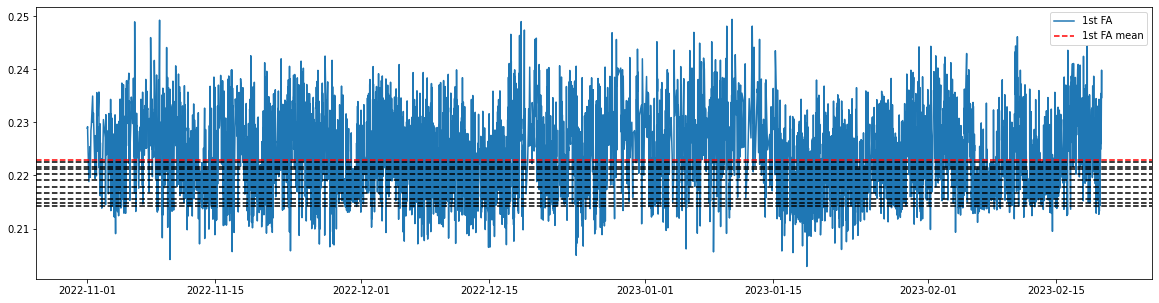

In [ ]:
mode = '1st FA'
plt.figure(figsize=(20, 5))
plt.plot(FA1.frequency, label=mode)
plt.axhline(FA1.frequency.mean(), color='red', linestyle= '--', label=mode + ' mean')
for key in average_diff.keys():
    print(average_diff[key][mode])
    plt.axhline(FA1.frequency.mean() - average_diff[key][mode] * FA1.frequency.mean(), color='k', linestyle= '--')
plt.legend()
plt.show()

0.007181500271053937
0.011324912150918567
0.01648496119717332
0.02191265339144397
0.02736347860980863
0.03202666135929404
0.0357737273449189
0.037932848552005675
0.0012762979501704961
0.0050507037188709525


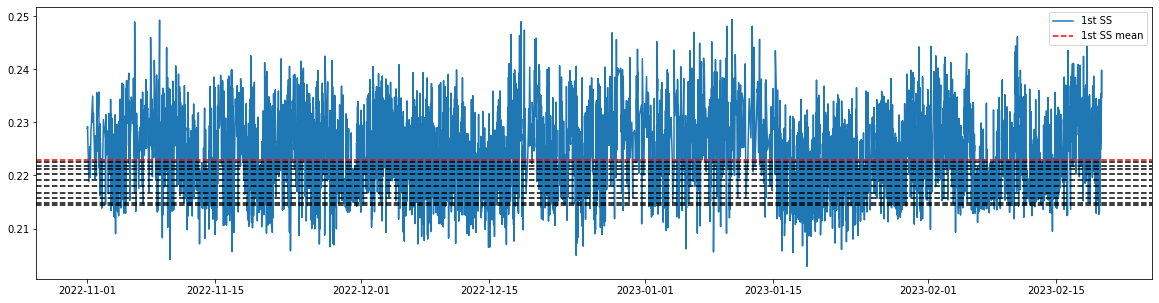

In [ ]:
mode = '1st SS'
plt.figure(figsize=(20, 5))
plt.plot(SS1.frequency, label=mode)
plt.axhline(SS1.frequency.mean(), color='red', linestyle= '--', label=mode + ' mean')
for key in average_diff.keys():
    print(average_diff[key][mode])
    plt.axhline(SS1.frequency.mean() - average_diff[key][mode] * SS1.frequency.mean(), color='k', linestyle= '--')
plt.legend()
plt.show()

0.019026090862510562
0.029688832987578184
0.042758415431704846
0.05620969973327531
0.06941864625790249
0.08045134187834783
0.08919449364611641
0.09418428676254255
0.0034898555705764034
0.013513089683668178


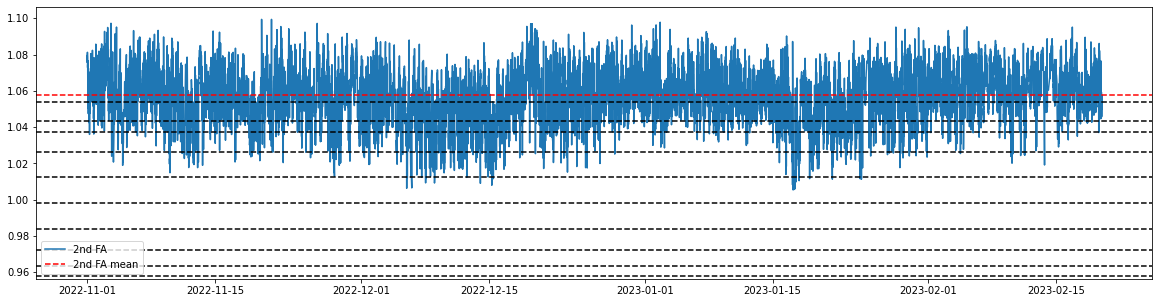

In [ ]:
mode = '2nd FA'
plt.figure(figsize=(20, 5))
plt.plot(FA2.frequency, label=mode)
plt.axhline(FA2.frequency.mean(), color='red', linestyle= '--', label=mode + ' mean')
for key in average_diff.keys():
    print(average_diff[key][mode])
    plt.axhline(FA2.frequency.mean() - average_diff[key][mode] * FA2.frequency.mean(), color='k', linestyle= '--')
plt.legend()
plt.show()

0.016688203924103116
0.02613455031417662
0.03779614489350923
0.04988922305715026
0.061851178229888344
0.07190563647458335
0.07991156972597556
0.08449445908273537
0.0030412112330808405
0.011827191615880356


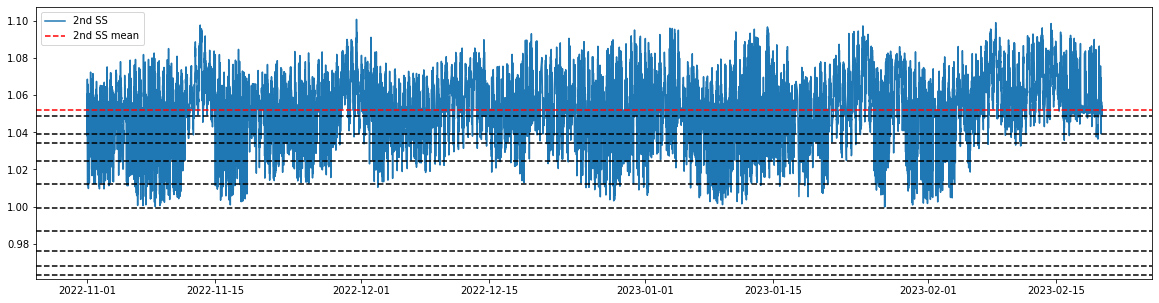

In [ ]:
mode = '2nd SS'
plt.figure(figsize=(20, 5))
plt.plot(SS2.frequency, label=mode)
plt.axhline(SS2.frequency.mean(), color='red', linestyle= '--', label=mode + ' mean')
for key in average_diff.keys():
    print(average_diff[key][mode])
    plt.axhline(SS2.frequency.mean() - average_diff[key][mode] * SS2.frequency.mean(), color='k', linestyle= '--')
plt.legend()
plt.show()

In [ ]:
tracked_modes[mode].loc[tracked_modes[mode].index.intersection(parked_data.index)].frequency.mean()

1.071317029897405

In [ ]:
average_diff.keys()

dict_keys(['Eigen_parked_LS_0.1D', 'Eigen_parked_LS_0.2D', 'Eigen_parked_LS_0.3D', 'Eigen_parked_LS_0.4D', 'Eigen_parked_LS_0.5D', 'Eigen_parked_LS_0.6D', 'Eigen_parked_LS_0.7D', 'Eigen_parked_LS_0.8D', 'Eigen_parked_scour_1', 'Eigen_parked_scour_2'])

In [ ]:
average_diff_parked

{'Eigen_parked_LS_0.1D': 1st SS        0.007182
 1st FA        0.007281
 2nd SS        0.016688
 2nd FA        0.019026
 SWL [mLAT]    0.000000
 dtype: float64,
 'Eigen_parked_LS_0.2D': 1st SS        0.011325
 1st FA        0.011481
 2nd SS        0.026135
 2nd FA        0.029689
 SWL [mLAT]    0.000000
 dtype: float64,
 'Eigen_parked_LS_0.3D': 1st SS        0.016485
 1st FA        0.016710
 2nd SS        0.037796
 2nd FA        0.042758
 SWL [mLAT]    0.000000
 dtype: float64,
 'Eigen_parked_LS_0.4D': 1st SS        0.021913
 1st FA        0.022209
 2nd SS        0.049889
 2nd FA        0.056210
 SWL [mLAT]    0.000000
 dtype: float64,
 'Eigen_parked_LS_0.5D': 1st SS        0.027363
 1st FA        0.027731
 2nd SS        0.061851
 2nd FA        0.069419
 SWL [mLAT]    0.000000
 dtype: float64,
 'Eigen_parked_LS_0.6D': 1st SS        0.032027
 1st FA        0.032453
 2nd SS        0.071906
 2nd FA        0.080451
 SWL [mLAT]    0.000000
 dtype: float64,
 'Eigen_parked_LS_0.7D': 1st SS   

C:\Users\Max\AppData\Local\Temp\ipykernel_18584\2576983484.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  ref = simulation_data[key].mean()
C:\Users\Max\AppData\Local\Temp\ipykernel_18584\2576983484.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  average_diff[key] = (ref - simulation_data[key].mean())/ref


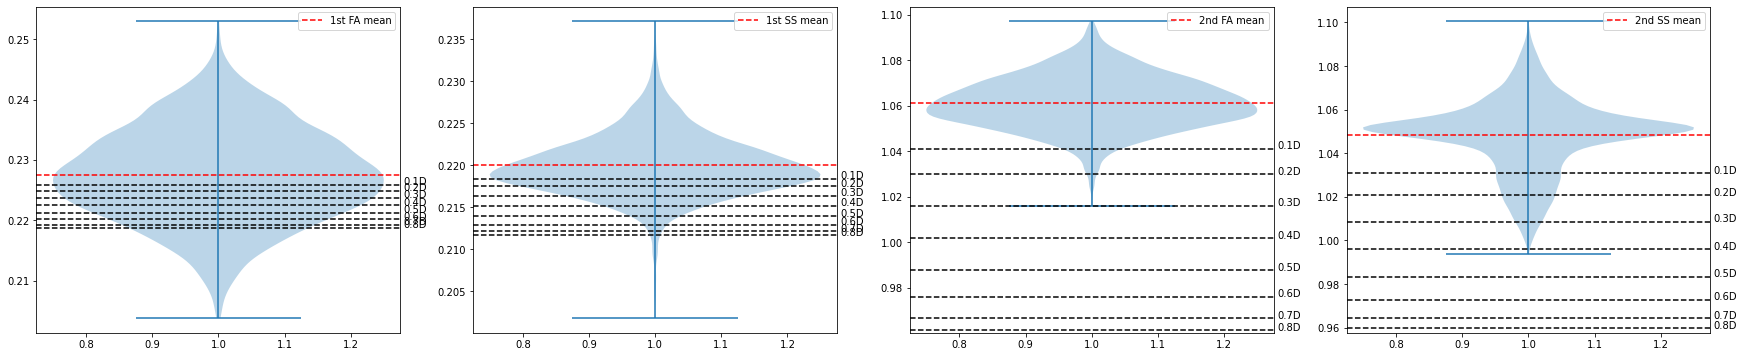

In [ ]:
modes = ['1st FA', '1st SS', '2nd FA', '2nd SS']
scours = ['0.1D', '0.2D', '0.3D', '0.4D', '0.5D', '0.6D', '0.7D', '0.8D']
average_diff_parked = get_average_diff(simulation_data, 'parked')
fig, axs = plt.subplots(1, len(modes), figsize=(30, 6))
i = 0
for mode in modes:
    data = tracked_modes[mode].loc[tracked_modes[mode].index.intersection(rated_data.index)].frequency
    axs[i].violinplot(data)
    axs[i].axhline(data.mean(), color='red', linestyle= '--', label=mode + ' mean')
    for key in average_diff_parked.keys():
        if 'LS' in key:
            axs[i].axhline(data.mean() - average_diff_parked[key][mode] * data.mean(), color='k', linestyle= '--')
            axs[i].text(1.28, data.mean() - average_diff_parked[key][mode] * data.mean(), key.split('_')[3])
    axs[i].legend()
    i += 1
plt.show()

C:\Users\Max\AppData\Local\Temp\ipykernel_18584\2576983484.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  ref = simulation_data[key].mean()
C:\Users\Max\AppData\Local\Temp\ipykernel_18584\2576983484.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  average_diff[key] = (ref - simulation_data[key].mean())/ref


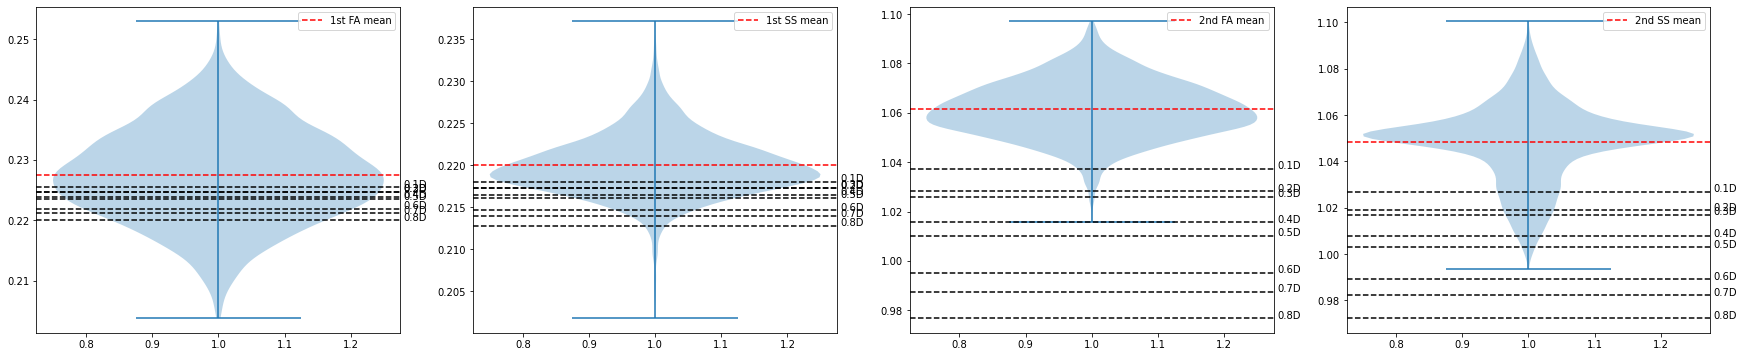

In [ ]:
modes = ['1st FA', '1st SS', '2nd FA', '2nd SS']
scours = ['0.1D', '0.2D', '0.3D', '0.4D', '0.5D', '0.6D', '0.7D', '0.8D']
average_diff_rated = get_average_diff(simulation_data, 'rated')
fig, axs = plt.subplots(1, len(modes), figsize=(30, 6))
i = 0
for mode in modes:
    data = tracked_modes[mode].loc[tracked_modes[mode].index.intersection(rated_data.index)].frequency
    axs[i].violinplot(data)
    axs[i].axhline(data.mean(), color='red', linestyle= '--', label=mode + ' mean')
    for key in average_diff_rated.keys():
        if 'LS' in key:
            axs[i].axhline(data.mean() - average_diff_rated[key][mode] * data.mean(), color='k', linestyle= '--')
            axs[i].text(1.28, data.mean() - average_diff_rated[key][mode] * data.mean(), key.split('_')[3])
    axs[i].legend()
    i += 1
plt.show()

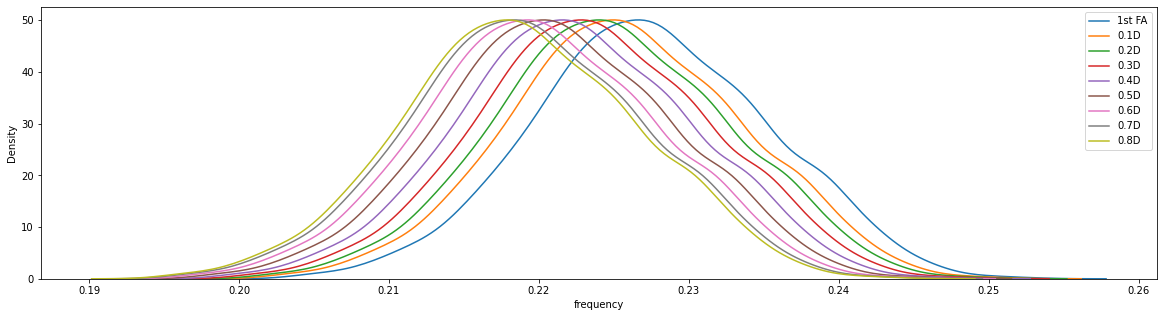

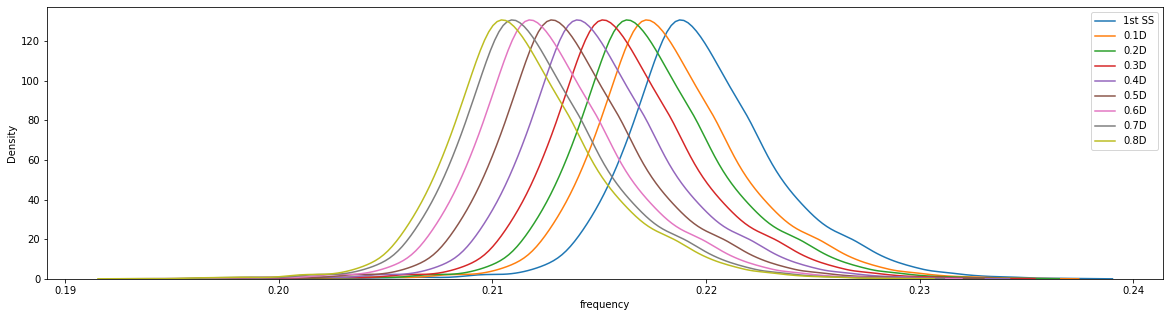

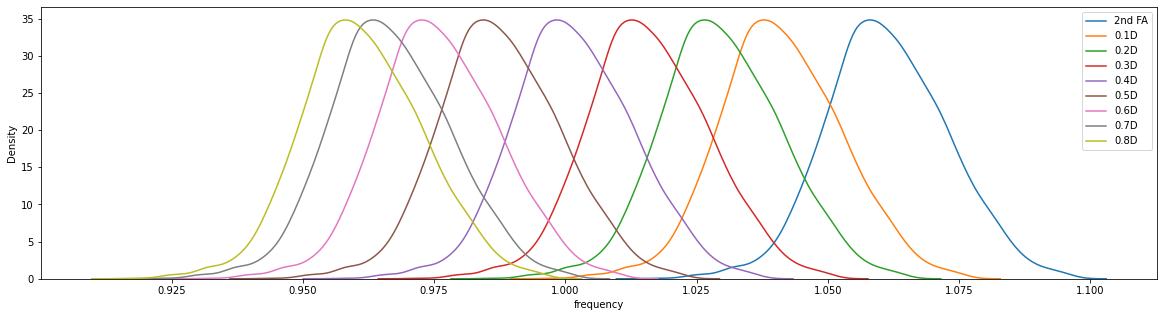

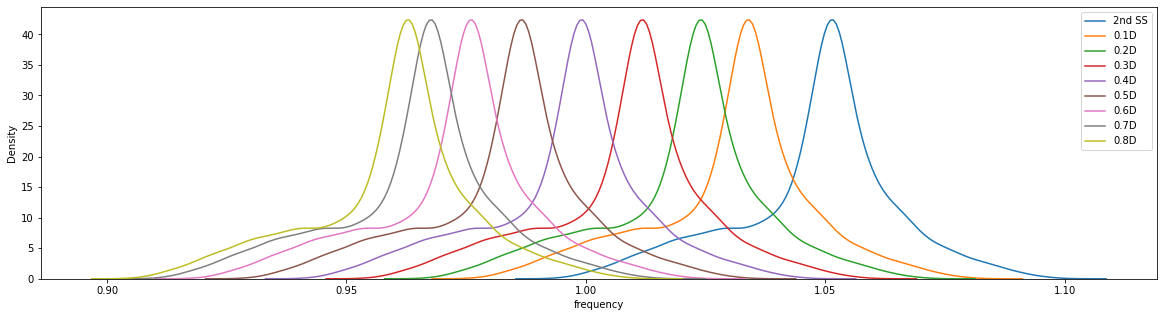

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from scipy.stats import ks_2samp

modes = ['1st FA', '1st SS', '2nd FA', '2nd SS']
scours = ['0.1D', '0.2D', '0.3D', '0.4D', '0.5D', '0.6D', '0.7D', '0.8D']
average_diff_parked = get_average_diff(simulation_data, 'parked')
ks_statistics = pd.DataFrame(columns = modes, index = scours)
i = 0
for mode in modes:
    figure = plt.figure(figsize=(20, 5))
    data = tracked_modes[mode].loc[tracked_modes[mode].index.intersection(rated_data.index)].frequency
    sns.distplot(data, hist=False, label=mode)
    axs[i].axhline(data.mean(), color='red', linestyle= '--', label=mode + ' mean')
    ks_statistics[mode] = pd.DataFrame
    for key in average_diff_parked.keys():
        if 'LS' in key:
            sns.distplot(data - average_diff_parked[key][mode] * data.mean(), hist=False, label=key.split('_')[3])
            ks_statistic, p_value = ks_2samp(data, data - average_diff_parked[key][mode] * data.mean())
            #print(key, ', KS statistic: ', ks_statistic)
            ks_statistics[mode][key.split('_')[3]] = ks_statistic
    plt.legend()
    i += 1
    plt.show()

Text(0.5, 1.0, 'KS statistics')

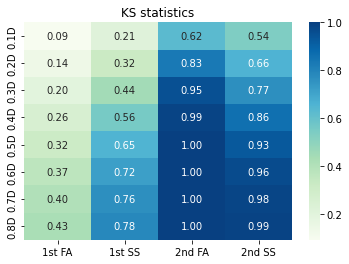

In [ ]:
import numpy as np
sns.heatmap(ks_statistics.astype(float), cmap='GnBu', annot=True, fmt='.2f')
plt.title('KS statistics')